# DQN with rated memory replay

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
import numpy as np

state = env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action) # take a random action
    batch.append([state, action, next_state, reward, float(done)])
    #     print('state, action, reward, done, info:', 
    #           state, action, reward, done, info)
    state = next_state
    if done:
        state = env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][0].shape

([array([-0.02969866, -0.00653224,  0.02312805,  0.02640354]),
  0,
  array([-0.02982931, -0.2019781 ,  0.02365612,  0.32629297]),
  1.0,
  0.0],
 (4,))

In [6]:
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 float64
1 0
2
1.0 1.0
2.3289356179120473 -2.478005359165808


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [10]:
def model_loss(states, actions, targetQs, action_size, hidden_size):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    #Qs = tf.reduce_max(actions_logits, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, loss

In [11]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
def sample(batch_size, ListArr):
    idx = np.random.choice(np.arange(len(ListArr)), 
                           size=batch_size, 
                           replace=True)
    return [ListArr[ii] for ii in idx]

In [14]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [15]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [19]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size
gamma = 0.99                   # future reward discount

In [20]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [21]:
state = env.reset() # env-based
total_reward = 0 # episode R
num_step = 0 # episode steps/ length based on number of steps
for _ in range(memory_size):
    action = env.action_space.sample() # exploring the env action space/ random action/ explore
    next_state, reward, done, _ = env.step(action) # exploring the env state, reward, and done/end
    memory.buffer.append([state, action, next_state, reward, float(done), -1])
    num_step += 1 # memory incremented
    total_reward += reward # R += r
    state = next_state # update the state for next episode
    if done is True: # end of this episode
        state = env.reset() # reset for next episode
        rate = total_reward/500 # the actual sucess rate of the played sequence
        # clipping not needed- 0-1
        total_reward = 0 # reset for next episode
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                memory.buffer[-1-idx][5] = rate # rate each SA pair
        num_step = 0 # reset for the next episode

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0
        loss_batch = []
        state = env.reset()
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), -1])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state

            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                        memory.buffer[-1-idx][5] = rate # rate each SA pair

            # Training using a max rated batch
            while True:
                #idx = np.random.choice(np.arange(memory_size// batch_size))
                #batch = np.array(memory.buffer)[idx*batch_size:(idx+1)*batch_size]
                batch = np.array(memory.buffer)
                rates = np.array([each[5] for each in batch])            
                batch = batch[rates >= (np.max(rates)*0.5)]
                if (np.max(rates)*0.5) > 0 and len(batch) > (2 * batch_size): 
                    break
            batch = sample(ListArr=batch, batch_size=batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            #nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:29.0000 R:29.0 rate:0.0580 loss:1.2729 exploreP:0.9971
Episode:1 meanR:32.0000 R:35.0 rate:0.0700 loss:1.3179 exploreP:0.9937
Episode:2 meanR:25.0000 R:11.0 rate:0.0220 loss:1.3902 exploreP:0.9926
Episode:3 meanR:22.5000 R:15.0 rate:0.0300 loss:1.3913 exploreP:0.9911
Episode:4 meanR:23.6000 R:28.0 rate:0.0560 loss:1.4377 exploreP:0.9884
Episode:5 meanR:23.6667 R:24.0 rate:0.0480 loss:1.5248 exploreP:0.9860
Episode:6 meanR:25.0000 R:33.0 rate:0.0660 loss:1.5580 exploreP:0.9828
Episode:7 meanR:24.2500 R:19.0 rate:0.0380 loss:1.6250 exploreP:0.9810
Episode:8 meanR:23.2222 R:15.0 rate:0.0300 loss:1.6778 exploreP:0.9795
Episode:9 meanR:22.0000 R:11.0 rate:0.0220 loss:1.6896 exploreP:0.9785
Episode:10 meanR:22.6364 R:29.0 rate:0.0580 loss:1.7482 exploreP:0.9757
Episode:11 meanR:24.0833 R:40.0 rate:0.0800 loss:1.8417 exploreP:0.9718
Episode:12 meanR:23.8462 R:21.0 rate:0.0420 loss:1.9575 exploreP:0.9698
Episode:13 meanR:22.9286 R:11.0 rate:0.0220 loss:1.9134 exploreP:0.9687
Ep

Episode:113 meanR:21.5100 R:13.0 rate:0.0260 loss:350.7417 exploreP:0.7832
Episode:114 meanR:21.4300 R:17.0 rate:0.0340 loss:374.2448 exploreP:0.7819
Episode:115 meanR:21.4500 R:12.0 rate:0.0240 loss:364.3551 exploreP:0.7809
Episode:116 meanR:21.3900 R:10.0 rate:0.0200 loss:373.9676 exploreP:0.7802
Episode:117 meanR:21.3300 R:13.0 rate:0.0260 loss:393.5031 exploreP:0.7792
Episode:118 meanR:21.0900 R:10.0 rate:0.0200 loss:381.9868 exploreP:0.7784
Episode:119 meanR:21.0900 R:18.0 rate:0.0360 loss:392.8200 exploreP:0.7770
Episode:120 meanR:21.1500 R:16.0 rate:0.0320 loss:420.4467 exploreP:0.7758
Episode:121 meanR:21.1100 R:13.0 rate:0.0260 loss:430.9915 exploreP:0.7748
Episode:122 meanR:21.1600 R:32.0 rate:0.0640 loss:481.1676 exploreP:0.7723
Episode:123 meanR:20.7900 R:11.0 rate:0.0220 loss:478.7029 exploreP:0.7715
Episode:124 meanR:20.7400 R:17.0 rate:0.0340 loss:508.1331 exploreP:0.7702
Episode:125 meanR:21.3900 R:74.0 rate:0.1480 loss:559.7117 exploreP:0.7646
Episode:126 meanR:21.2400

Episode:222 meanR:18.0200 R:9.0 rate:0.0180 loss:8605.3643 exploreP:0.6466
Episode:223 meanR:18.0200 R:11.0 rate:0.0220 loss:8620.5068 exploreP:0.6459
Episode:224 meanR:17.9700 R:12.0 rate:0.0240 loss:8618.2383 exploreP:0.6452
Episode:225 meanR:17.4500 R:22.0 rate:0.0440 loss:8958.2852 exploreP:0.6438
Episode:226 meanR:17.5300 R:17.0 rate:0.0340 loss:8939.2041 exploreP:0.6427
Episode:227 meanR:17.5000 R:9.0 rate:0.0180 loss:9281.6367 exploreP:0.6421
Episode:228 meanR:17.4700 R:13.0 rate:0.0260 loss:8778.5127 exploreP:0.6413
Episode:229 meanR:17.5200 R:28.0 rate:0.0560 loss:9517.4561 exploreP:0.6395
Episode:230 meanR:17.5000 R:14.0 rate:0.0280 loss:9803.4014 exploreP:0.6387
Episode:231 meanR:17.4500 R:9.0 rate:0.0180 loss:9434.8623 exploreP:0.6381
Episode:232 meanR:17.2300 R:9.0 rate:0.0180 loss:9995.8262 exploreP:0.6375
Episode:233 meanR:16.7200 R:8.0 rate:0.0160 loss:10356.6621 exploreP:0.6370
Episode:234 meanR:16.6100 R:14.0 rate:0.0280 loss:10429.1709 exploreP:0.6362
Episode:235 mea

Episode:329 meanR:14.9700 R:15.0 rate:0.0300 loss:39727.5820 exploreP:0.5520
Episode:330 meanR:14.9600 R:13.0 rate:0.0260 loss:39349.4336 exploreP:0.5513
Episode:331 meanR:15.0500 R:18.0 rate:0.0360 loss:38200.5781 exploreP:0.5503
Episode:332 meanR:15.1400 R:18.0 rate:0.0360 loss:39480.0000 exploreP:0.5494
Episode:333 meanR:15.2300 R:17.0 rate:0.0340 loss:40042.1992 exploreP:0.5485
Episode:334 meanR:15.2500 R:16.0 rate:0.0320 loss:41264.2227 exploreP:0.5476
Episode:335 meanR:15.3100 R:17.0 rate:0.0340 loss:42417.5742 exploreP:0.5467
Episode:336 meanR:15.2300 R:13.0 rate:0.0260 loss:45071.5352 exploreP:0.5460
Episode:337 meanR:15.1200 R:12.0 rate:0.0240 loss:45009.5938 exploreP:0.5453
Episode:338 meanR:15.1300 R:12.0 rate:0.0240 loss:45062.8281 exploreP:0.5447
Episode:339 meanR:15.1300 R:16.0 rate:0.0320 loss:45427.7891 exploreP:0.5438
Episode:340 meanR:15.1400 R:13.0 rate:0.0260 loss:44527.3320 exploreP:0.5432
Episode:341 meanR:15.1800 R:15.0 rate:0.0300 loss:44162.1094 exploreP:0.5424

Episode:436 meanR:13.7700 R:9.0 rate:0.0180 loss:108169.4062 exploreP:0.4770
Episode:437 meanR:13.7700 R:12.0 rate:0.0240 loss:105293.6562 exploreP:0.4765
Episode:438 meanR:13.7400 R:9.0 rate:0.0180 loss:102766.7500 exploreP:0.4761
Episode:439 meanR:13.6700 R:9.0 rate:0.0180 loss:106218.7812 exploreP:0.4756
Episode:440 meanR:13.6300 R:9.0 rate:0.0180 loss:106013.8203 exploreP:0.4752
Episode:441 meanR:13.6100 R:13.0 rate:0.0260 loss:107637.0156 exploreP:0.4746
Episode:442 meanR:13.6100 R:11.0 rate:0.0220 loss:106187.8281 exploreP:0.4741
Episode:443 meanR:13.7100 R:20.0 rate:0.0400 loss:103738.5781 exploreP:0.4732
Episode:444 meanR:13.7400 R:13.0 rate:0.0260 loss:105228.6094 exploreP:0.4726
Episode:445 meanR:13.7400 R:10.0 rate:0.0200 loss:106639.2266 exploreP:0.4721
Episode:446 meanR:13.6700 R:16.0 rate:0.0320 loss:105030.8438 exploreP:0.4714
Episode:447 meanR:13.6600 R:11.0 rate:0.0220 loss:104314.5703 exploreP:0.4709
Episode:448 meanR:13.6200 R:10.0 rate:0.0200 loss:106869.1406 explor

Episode:542 meanR:12.9200 R:14.0 rate:0.0280 loss:143818.2031 exploreP:0.4179
Episode:543 meanR:12.9500 R:23.0 rate:0.0460 loss:147570.4688 exploreP:0.4169
Episode:544 meanR:12.9200 R:10.0 rate:0.0200 loss:158364.1719 exploreP:0.4165
Episode:545 meanR:12.9700 R:15.0 rate:0.0300 loss:158235.2812 exploreP:0.4159
Episode:546 meanR:12.9000 R:9.0 rate:0.0180 loss:143428.6719 exploreP:0.4155
Episode:547 meanR:12.9000 R:11.0 rate:0.0220 loss:148922.4375 exploreP:0.4151
Episode:548 meanR:12.9000 R:10.0 rate:0.0200 loss:140163.8438 exploreP:0.4147
Episode:549 meanR:12.9200 R:12.0 rate:0.0240 loss:150423.4688 exploreP:0.4142
Episode:550 meanR:12.9400 R:12.0 rate:0.0240 loss:145980.0156 exploreP:0.4137
Episode:551 meanR:12.9200 R:10.0 rate:0.0200 loss:158228.9219 exploreP:0.4133
Episode:552 meanR:12.8300 R:9.0 rate:0.0180 loss:152013.5781 exploreP:0.4129
Episode:553 meanR:12.7500 R:10.0 rate:0.0200 loss:152574.7031 exploreP:0.4125
Episode:554 meanR:12.7800 R:12.0 rate:0.0240 loss:150785.7344 expl

Episode:648 meanR:12.4900 R:13.0 rate:0.0260 loss:142727.0156 exploreP:0.3672
Episode:649 meanR:12.4600 R:9.0 rate:0.0180 loss:140645.7656 exploreP:0.3668
Episode:650 meanR:12.4900 R:15.0 rate:0.0300 loss:136101.2969 exploreP:0.3663
Episode:651 meanR:12.4800 R:9.0 rate:0.0180 loss:135774.4844 exploreP:0.3660
Episode:652 meanR:12.4800 R:9.0 rate:0.0180 loss:139935.0156 exploreP:0.3657
Episode:653 meanR:12.5200 R:14.0 rate:0.0280 loss:141200.4844 exploreP:0.3652
Episode:654 meanR:12.5300 R:13.0 rate:0.0260 loss:145727.4375 exploreP:0.3647
Episode:655 meanR:12.5300 R:10.0 rate:0.0200 loss:140595.6562 exploreP:0.3644
Episode:656 meanR:12.4500 R:8.0 rate:0.0160 loss:140823.6875 exploreP:0.3641
Episode:657 meanR:12.4600 R:15.0 rate:0.0300 loss:141858.4219 exploreP:0.3635
Episode:658 meanR:12.4000 R:9.0 rate:0.0180 loss:128355.7891 exploreP:0.3632
Episode:659 meanR:12.3800 R:13.0 rate:0.0260 loss:132842.1719 exploreP:0.3628
Episode:660 meanR:12.2900 R:10.0 rate:0.0200 loss:128669.8906 explore

Episode:754 meanR:11.7700 R:14.0 rate:0.0280 loss:104328.6875 exploreP:0.3253
Episode:755 meanR:11.7600 R:9.0 rate:0.0180 loss:92543.0625 exploreP:0.3250
Episode:756 meanR:11.8100 R:13.0 rate:0.0260 loss:105761.6250 exploreP:0.3246
Episode:757 meanR:11.7400 R:8.0 rate:0.0160 loss:102984.4922 exploreP:0.3244
Episode:758 meanR:11.7600 R:11.0 rate:0.0220 loss:97049.8281 exploreP:0.3240
Episode:759 meanR:11.7300 R:10.0 rate:0.0200 loss:95308.6719 exploreP:0.3237
Episode:760 meanR:11.7400 R:11.0 rate:0.0220 loss:100951.0547 exploreP:0.3234
Episode:761 meanR:11.8200 R:20.0 rate:0.0400 loss:98460.3828 exploreP:0.3228
Episode:762 meanR:11.8300 R:10.0 rate:0.0200 loss:105505.7891 exploreP:0.3224
Episode:763 meanR:11.8500 R:10.0 rate:0.0200 loss:103540.5312 exploreP:0.3221
Episode:764 meanR:11.8700 R:11.0 rate:0.0220 loss:99377.9219 exploreP:0.3218
Episode:765 meanR:11.8700 R:11.0 rate:0.0220 loss:97186.9531 exploreP:0.3214
Episode:766 meanR:11.8100 R:10.0 rate:0.0200 loss:96258.7109 exploreP:0.

Episode:861 meanR:11.6800 R:10.0 rate:0.0200 loss:58750.9453 exploreP:0.2883
Episode:862 meanR:11.7200 R:14.0 rate:0.0280 loss:62140.2578 exploreP:0.2879
Episode:863 meanR:11.7500 R:13.0 rate:0.0260 loss:61518.3477 exploreP:0.2875
Episode:864 meanR:11.7700 R:13.0 rate:0.0260 loss:58248.0586 exploreP:0.2872
Episode:865 meanR:11.7700 R:11.0 rate:0.0220 loss:56770.2109 exploreP:0.2869
Episode:866 meanR:11.7700 R:10.0 rate:0.0200 loss:55347.7109 exploreP:0.2866
Episode:867 meanR:11.7700 R:9.0 rate:0.0180 loss:56617.7656 exploreP:0.2863
Episode:868 meanR:11.7900 R:13.0 rate:0.0260 loss:57001.2656 exploreP:0.2860
Episode:869 meanR:11.7600 R:13.0 rate:0.0260 loss:57601.1094 exploreP:0.2856
Episode:870 meanR:11.7200 R:11.0 rate:0.0220 loss:58049.2266 exploreP:0.2853
Episode:871 meanR:11.7100 R:14.0 rate:0.0280 loss:55693.0977 exploreP:0.2849
Episode:872 meanR:11.7000 R:11.0 rate:0.0220 loss:54893.1719 exploreP:0.2846
Episode:873 meanR:11.7100 R:10.0 rate:0.0200 loss:59059.0000 exploreP:0.2844


Episode:968 meanR:10.6600 R:12.0 rate:0.0240 loss:31867.2520 exploreP:0.2581
Episode:969 meanR:10.6600 R:13.0 rate:0.0260 loss:33635.8555 exploreP:0.2577
Episode:970 meanR:10.6500 R:10.0 rate:0.0200 loss:31076.3438 exploreP:0.2575
Episode:971 meanR:10.6100 R:10.0 rate:0.0200 loss:29817.9688 exploreP:0.2573
Episode:972 meanR:10.6200 R:12.0 rate:0.0240 loss:33215.1797 exploreP:0.2570
Episode:973 meanR:10.6300 R:11.0 rate:0.0220 loss:30931.3730 exploreP:0.2567
Episode:974 meanR:10.6200 R:11.0 rate:0.0220 loss:30379.8730 exploreP:0.2564
Episode:975 meanR:10.6200 R:11.0 rate:0.0220 loss:29841.2012 exploreP:0.2561
Episode:976 meanR:10.6500 R:14.0 rate:0.0280 loss:30198.1348 exploreP:0.2558
Episode:977 meanR:10.6400 R:9.0 rate:0.0180 loss:30361.5000 exploreP:0.2556
Episode:978 meanR:10.7300 R:23.0 rate:0.0460 loss:30048.3203 exploreP:0.2550
Episode:979 meanR:10.7400 R:11.0 rate:0.0220 loss:29303.3887 exploreP:0.2547
Episode:980 meanR:10.7700 R:16.0 rate:0.0320 loss:30807.9922 exploreP:0.2544


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

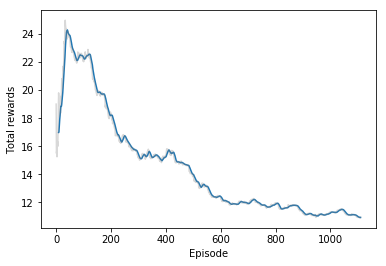

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

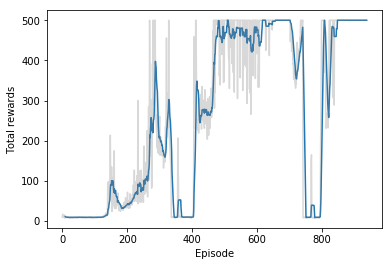

In [24]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Average losses')

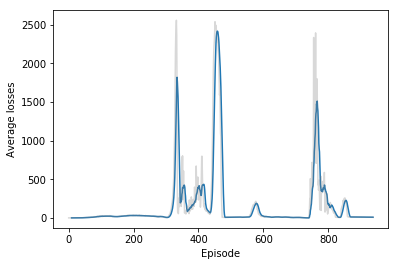

In [25]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.